[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YKochura/nn-kpi/blob/main/tutor/unet.ipynb)

#  UNet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

random.seed(32)
torch.manual_seed(32)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Load segmentation data

In [3]:
! git clone https://github.com/hoangp/isbi-datasets.git

fatal: destination path 'isbi-datasets' already exists and is not an empty directory.


In [4]:
# Load ISBI 2012 data
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from PIL import Image
import os

images_dir = "/content/isbi-datasets/data/images/"
labels_dir = "/content/isbi-datasets/data/labels/"

image_files = sorted(os.listdir(images_dir))
label_files = sorted(os.listdir(labels_dir))

In [5]:
# Crop and transforms
def random_crop(image, label, size=(128, 128)):
    i, j, h, w = transforms.RandomCrop.get_params(image, output_size=size)
    image = TF.crop(image, i, j, h, w)
    label = TF.crop(label, i, j, h, w)
    return image, label

image_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
])

# Load and process images and labels
N = 5000
X = []
Y = []

for _ in range(N):
    i = random.randint(0, len(image_files) - 1)

    image = Image.open(os.path.join(images_dir, image_files[i]))
    label = Image.open(os.path.join(labels_dir, label_files[i]))

    image, label = random_crop(image, label)
    image = image_transform(image)
    label = image_transform(label)

    X.append(image)
    Y.append(label)

# Stack tensors
X = torch.stack(X).to(device)
X = (X - X.mean()) / X.std()
Y = torch.stack(Y).to(device)
Y = (Y < 0.5).float()

In [6]:
# Data loader
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

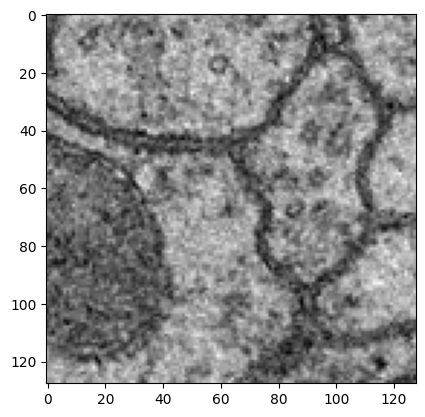

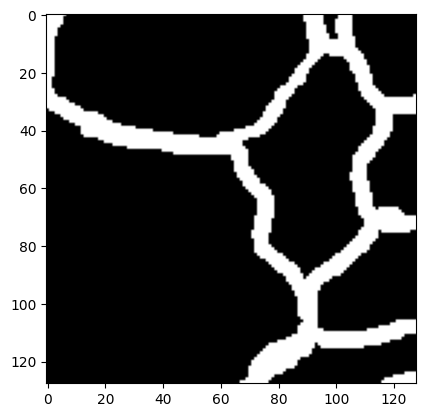

In [7]:
# Display images
i = random.randint(0, N)

plt.imshow(X[i].squeeze().cpu().numpy(), cmap="gray")
plt.show()

plt.imshow(Y[i].squeeze().cpu().numpy(), cmap="gray")
plt.show()

# UNet model

In [8]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU()
        )

    def forward(self, x):
        #print(f"Block: x.shape = {x.shape}, out_channels = {self.block[0].out_channels}")
        return self.block(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = Block(in_channels, out_channels)
        self.down = nn.MaxPool2d(2)

    def forward(self, x):
        #print(f"Down: x.shape = {x.shape}")
        x = self.block(x)
        x_down = self.down(x)
        return x, x_down

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2)
        self.block = Block(in_channels + in_channels, out_channels)

    def forward(self, x, skip):
        #print(f"Up: x.shape = {x.shape}, skip.shape = {skip.shape}")
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.block(x)
        return x

class TinyUnet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.down1 = Down(in_channels, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.middle = Block(256, 256)
        self.up3 = Up(256, 128)
        self.up2 = Up(128, 64)
        self.up1 = Up(64, 32)
        self.conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # x is (B, in_channels, H, W)
        x1, x = self.down1(x)  # x1 is (B, 64, H, W), x is (B, 64, H/2, W/2)
        x2, x = self.down2(x)  # x2 is (B, 128, H/2, W/2), x is (B, 128, H/4, W/4)
        x3, x = self.down3(x)  # x3 is (B, 256, H/4, W/4), x is (B, 256, H/8, W/8)
        x = self.middle(x)     # x is (B, 256, H/8, W/8)
        x = self.up3(x, x3)    # x is (B, 128, H/4, W/4)
        x = self.up2(x, x2)    # x is (B, 64, H/2, W/2)
        x = self.up1(x, x1)    # x is (B, 32, H, W)
        x = self.conv(x)       # x is (B, out_channels, H, W)
        return x

net = TinyUnet(1, 1).to(device)
net(X[:1])

tensor([[[[-0.0409, -0.0349, -0.0368,  ..., -0.0495, -0.0481, -0.0547],
          [-0.0343, -0.0370, -0.0389,  ..., -0.0570, -0.0519, -0.0573],
          [-0.0229, -0.0197, -0.0210,  ..., -0.0541, -0.0407, -0.0502],
          ...,
          [-0.0268, -0.0295, -0.0398,  ..., -0.0529, -0.0438, -0.0479],
          [-0.0414, -0.0485, -0.0572,  ..., -0.0473, -0.0482, -0.0576],
          [-0.0508, -0.0560, -0.0592,  ..., -0.0551, -0.0551, -0.0596]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)

In [9]:
# Training loop
optimizer = torch.optim.AdamW(net.parameters())
criterion = nn.BCEWithLogitsLoss()

for epoch in range(5):
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        y_pred = net(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}, loss = {loss.item()}")

Epoch 0, loss = 0.6820647120475769
Epoch 0, loss = 0.6726241111755371
Epoch 0, loss = 0.6658074855804443
Epoch 0, loss = 0.6412227749824524
Epoch 0, loss = 0.589095950126648
Epoch 0, loss = 0.8444651961326599
Epoch 0, loss = 0.5393916368484497
Epoch 0, loss = 0.5826915502548218
Epoch 0, loss = 0.5930099487304688
Epoch 0, loss = 0.5960949659347534
Epoch 0, loss = 0.5727729201316833
Epoch 0, loss = 0.5746300220489502
Epoch 0, loss = 0.5521007776260376
Epoch 0, loss = 0.5320866703987122
Epoch 0, loss = 0.5033321380615234
Epoch 0, loss = 0.44620147347450256
Epoch 0, loss = 0.4392014145851135
Epoch 0, loss = 0.39418089389801025
Epoch 0, loss = 0.3982572853565216
Epoch 0, loss = 0.39657315611839294
Epoch 0, loss = 0.4139045774936676
Epoch 0, loss = 0.38258296251296997
Epoch 0, loss = 0.3810899555683136
Epoch 0, loss = 0.39724695682525635
Epoch 0, loss = 0.41717809438705444
Epoch 0, loss = 0.3539547324180603
Epoch 0, loss = 0.428444504737854
Epoch 0, loss = 0.38524454832077026
Epoch 0, loss =

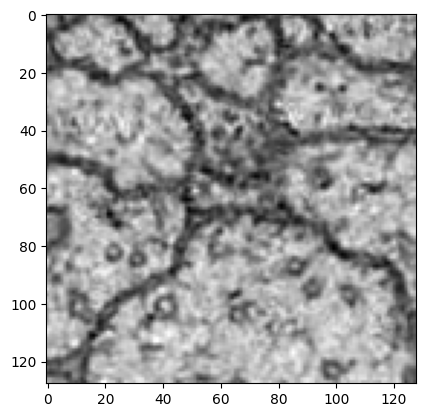

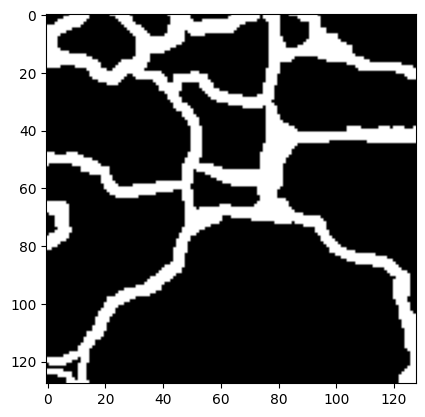

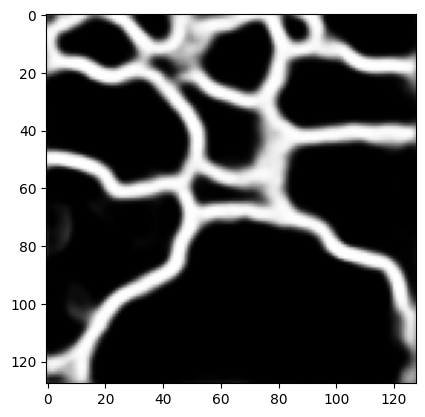

In [10]:
# Test
x, y = next(iter(dataloader))
y_pred = net(x.to(device))
y_pred = F.sigmoid(y_pred)

plt.imshow(x[0].squeeze().cpu().numpy(), cmap="gray")
plt.show()

plt.imshow(y[0].squeeze().cpu().numpy(), cmap="gray")
plt.show()

plt.imshow(y_pred[0].squeeze().cpu().detach().numpy(), cmap="gray")
plt.show()